In [1]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
from torch.utils.mobile_optimizer import optimize_for_mobile

In [2]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [27]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [29]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)


# Remove batch params for improved performance on NNAPI
# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=14,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes (required for batching)
                                'output' : {0 : 'batch_size'}})

# ORT NNAPI and TFLite don't support dynamic axes
# Remove batch params for improved performance on NNAPI
# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution_static.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=14,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  )

In [5]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [6]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [7]:
import cv2
import matplotlib.pyplot as plt


In [8]:
img = cv2.imread('cat.jpg')
imgYCC = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

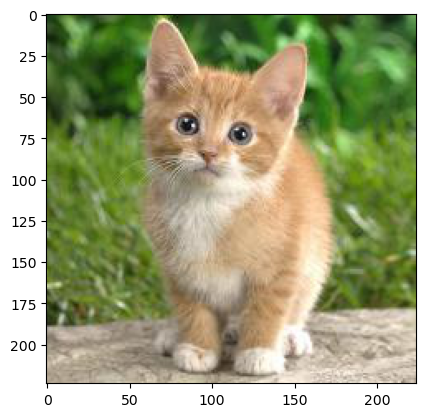

In [9]:
plt.imshow(rgb_img, cmap='gray')

In [10]:
img_y, img_cb, img_cr = cv2.split(imgYCC)
img_y_f = np.float32(img_y)/255

In [11]:
input_tensor = torch.from_numpy(img_y_f)
input_tensor.unsqueeze_(0).unsqueeze_(0)

tensor([[[[0.2196, 0.2000, 0.1922,  ..., 0.5294, 0.5569, 0.5725],
          [0.2078, 0.1961, 0.1922,  ..., 0.5333, 0.5569, 0.5725],
          [0.2000, 0.1882, 0.1882,  ..., 0.5216, 0.5412, 0.5529],
          ...,
          [0.6706, 0.6784, 0.6431,  ..., 0.6902, 0.6667, 0.6078],
          [0.6431, 0.6471, 0.6275,  ..., 0.8000, 0.7608, 0.6745],
          [0.6431, 0.6392, 0.6549,  ..., 0.8118, 0.7686, 0.6667]]]])

In [12]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_tensor)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

In [13]:
tensor_out_y = np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0])

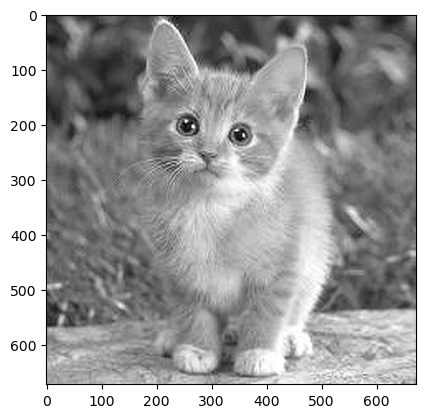

In [14]:
plt.imshow(tensor_out_y, cmap='gray')

In [15]:
tensor_out_y.shape[0]

672

In [16]:
img_out_cb = cv2.resize(img_cb, tensor_out_y.shape)

In [17]:
img_out_cr = cv2.resize(img_cr, tensor_out_y.shape)

In [18]:
out_image_YCC = cv2.merge((tensor_out_y, img_out_cb, img_out_cr))

In [19]:
out_image_bgr = cv2.cvtColor(out_image_YCC, cv2.COLOR_YCR_CB2BGR)
out_image_rgb = cv2.cvtColor(out_image_bgr, cv2.COLOR_BGR2RGB)

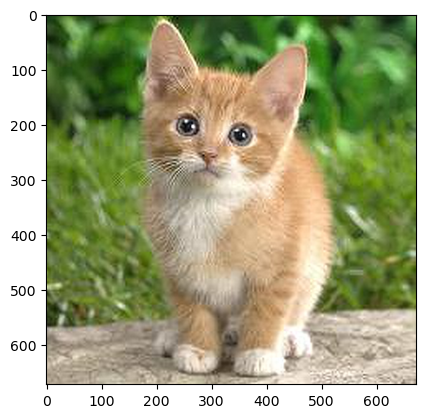

In [20]:
plt.imshow(out_image_rgb, cmap='gray')

In [ ]:
# Input to the model
rand_input = torch.rand(1, 1, 224, 224)
torchscript_model = torch.jit.trace(torch_model, rand_input)
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, "superres.pt")

#Vulkan NCHW Backend (Requires build with Vulkan back end enabled)
#nchw_script_module_optimized = optimize_for_mobile(torchscript_model, backend='vulkan')
#torch.jit.save(nchw_script_module_optimized, "superres_vulkan.pt")